# Test Project: Beer Reviews Analysis and Recommendation

Data: 1.5M beer reviews from beer advocate. (https://s3.amazonaws.com/demo-datasets/beer_reviews.tar.gz)



In [1]:
%matplotlib inline

### Import packages Numpy, Scikit Learn and Pandas

In [2]:
import numpy as np
import sklearn
import pandas as pd

Read in the "csv" file with reviews into a pandas "data frame". Pandas has this nice reader that can read a bunch of file formats and store the data in a "data frame"

In [3]:
beer_data = pd.read_csv('/Users/phani/Downloads/beer_reviews/beer_reviews.csv', delimiter=",", encoding='utf-8')
# download the revievs csv form the link above. Alternatively, use 'urlopen' and rebuild this command 
#to read the csv file after unzipping the response 

In [4]:
for i in range(len(beer_data.columns)):
    print("Column",i, ": ", beer_data.columns[i])

print ("*************************")
print("Columns with Null Values")
for column in beer_data.columns:
    count = len(beer_data.loc[pd.isnull(beer_data[column])])
    if count > 0 :
       print ("Column Name: ", column, " Null Values: ", count)

Column 0 :  brewery_id
Column 1 :  brewery_name
Column 2 :  review_time
Column 3 :  review_overall
Column 4 :  review_aroma
Column 5 :  review_appearance
Column 6 :  review_profilename
Column 7 :  beer_style
Column 8 :  review_palate
Column 9 :  review_taste
Column 10 :  beer_name
Column 11 :  beer_abv
Column 12 :  beer_beerid
*************************
Columns with Null Values
Column Name:  brewery_name  Null Values:  15
Column Name:  review_profilename  Null Values:  348
Column Name:  beer_abv  Null Values:  67785


####  Q1.Which brewery produces the strongest beers by ABV% - simple idea is to rank breweries based on the abv% of the beers produced by them.

The data in the csv file has some undefined ("NaN") values for abv%. More than one users have rated the beers (duplicate abv% values). For sorting and ranking, these things don't matter. This can be accomplished in two steps
- make a copy
- sort the data in "beer_abv" column in descending order
- pick the brewery that produces beer with highest abv%.

#### Details of the beer with highest abv%

In [5]:
beer_data_abv = beer_data.copy()
beer_data_abv_sorted = beer_data_abv.sort_values(by="beer_abv", ascending=False)
beer_data_abv_sorted = beer_data_abv_sorted.drop_duplicates("beer_beerid")
beer_key = beer_data_abv_sorted["beer_abv"].keys()[0]
print ("Brewery Name: ", beer_data_abv_sorted.loc[beer_key].brewery_name)
print ("Beer Name: ", beer_data_abv_sorted.loc[beer_key].beer_name)
print ("Beer ABV%: ", beer_data_abv_sorted.loc[beer_key].beer_abv)
print ("Beer ID: ", beer_data_abv_sorted.loc[beer_key].beer_beerid)

Brewery Name:  Schorschbräu
Beer Name:  Schorschbräu Schorschbock 57%
Beer ABV%:  57.7
Beer ID:  73368


#### Details of the top 5 beers sorted based on abv%

In [6]:
for i in range(5):
    beer_key = beer_data_abv_sorted["beer_abv"].keys()[i]
    print ("Beer No. :", i)
    print ("Brewery Name: ", beer_data_abv_sorted.loc[beer_key].brewery_name)
    print ("Beer Name: ", beer_data_abv_sorted.loc[beer_key].beer_name)
    print ("Beer ABV%: ", beer_data_abv_sorted.loc[beer_key].beer_abv)
    print ("Beer ID: ", beer_data_abv_sorted.loc[beer_key].beer_beerid)
#beer_data_abv_sorted.set_index(["beer_beerid"])
beer_data_abv_sorted[['brewery_name','beer_name', 'beer_abv','beer_beerid']][0:5]

Beer No. : 0
Brewery Name:  Schorschbräu
Beer Name:  Schorschbräu Schorschbock 57%
Beer ABV%:  57.7
Beer ID:  73368
Beer No. : 1
Brewery Name:  Schorschbräu
Beer Name:  Schorschbräu Schorschbock 43%
Beer ABV%:  43.0
Beer ID:  57856
Beer No. : 2
Brewery Name:  BrewDog
Beer Name:  Sink The Bismarck!
Beer ABV%:  41.0
Beer ID:  57015
Beer No. : 3
Brewery Name:  Schorschbräu
Beer Name:  Schorschbräu Schorschbock 40%
Beer ABV%:  39.44
Beer ID:  55712
Beer No. : 4
Brewery Name:  De Struise Brouwers
Beer Name:  Black Damnation VI - Messy
Beer ABV%:  39.0
Beer ID:  70633


,brewery_name,beer_name,beer_abv,beer_beerid
12919,Schorschbräu,Schorschbräu Schorschbock 57%,57.70,73368
12939,Schorschbräu,Schorschbräu Schorschbock 43%,43.00,57856
746385,BrewDog,Sink The Bismarck!,41.00,57015
12941,Schorschbräu,Schorschbräu Schorschbock 40%,39.44,55712
996153,De Struise Brouwers,Black Damnation VI - Messy,39.00,70633


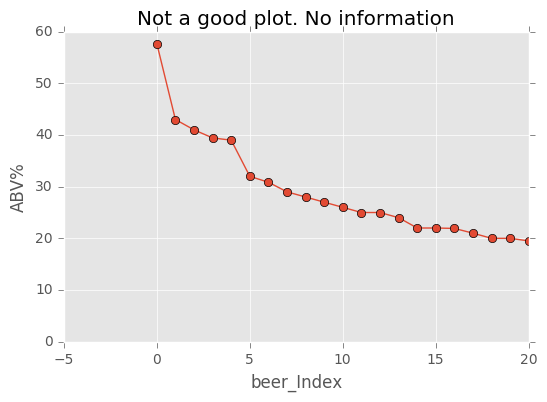

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import axes
from matplotlib import style
style.use('ggplot') # I don't really know how it works.. I am going to learn about it
#beer_data_abv_sorted = beer_data_abv_sorted.drop_duplicates("beer_beerid")

plt.plot(beer_data_abv_sorted["beer_abv"].get_values(), linestyle=None, marker='o')
plt.xlabel("beer_Index")
plt.ylabel("ABV%")
#plt.annotate()
plt.axis([-5, 20, 0, 60]) # plotting first 20 beers
plt.title ("Not a good plot. No information")
plt.show()

#### Q2. Recommend beers based on the data - Approach 1

A simple ordering of data based on review_overall should give us a list with beers and their corresponding ranking in the list. 

Data: number of reviews are not same for all beers. Some have only one review where as others have more than one reviews. We will define a threshold to clean up the data and include the beers with number of reviews greater than the threshold. Here I chose the threshold as 5.

The statistics way to chose the threshold number of reviews is to compute the minimum number of required reviews for a beer to predict the mean with a confidence interval of, lets say, 95%, is by calculating the formula ($\frac{\sigma^2 * Z^2}{m^2}$), where $\sigma$ is the standard deviation of the sample, Z-score for a confidence interval of 95% is 1.96 and m is the allowed margin of error.   

In [8]:
df = beer_data[["beer_beerid","beer_name","review_overall"]]
df = df.set_index(["beer_beerid","beer_name"])
grouped = df.groupby(level=0)
new_grouped = grouped.count()
#new_grouped

#### Q2. Recommend beers based on the data - Build a content-based recommendation system

Data Matrix: Lets assume that ratings are correct and correlate with user preferences. Data matrix contains overall reviews and users data. We collect user info based on review_profilename. Hence, some data points with missing "review_profilename" are dropped from the data matrix. 

Features Matrix: Features matrix contains four features (aroma, palette, appearance, taste) rated by different users. We assume that the rating is proportional to their tastes. We will not use ABV% here as one of the feature. It has many undefined values that could shrink our feature set.

We use linear regression with regularization to calculate the parameters that correlate features with overall rating. 



In [9]:
# check for any NA values in four features
beer_ratings = beer_data.dropna(how='any').loc[:,["beer_beerid","review_overall",
                                                  "review_taste","review_aroma",
                                                 "review_palate","review_appearance",
                                                 "review_profilename"]]
# Check for duplicate entries -  condition: same user, same rating and same beer_id
print (len(beer_ratings)) #- before duplicates removed
beer_ratings = beer_ratings.drop_duplicates()
print (len(beer_ratings)) #- after removing duplicates

1518478
1517728


In [10]:
beer_ratings = beer_ratings.drop_duplicates(subset=['beer_beerid','review_profilename'])
print (len(beer_ratings)) #- after removing duplicates

1504037


Create a data matrix (again a data frame) by rearranging the beer_ratings data frame using two indices and extracting the overall rating column

In [11]:
#beer_ratings.set_index(["beer_beerid","review_profilename"], inplace=True)
# Set indices
#beer_ratings.set_index(['beer_beerid','review_profilename'], inplace=True)
#beer_ratings
# Create a new dataframe which is our 'Data Matrix' that contains
# beer IDs as rows, usernames as columns and overall reviews as datapoints
# Some values are NA because all users didn't rate all beers
#beer_datamatrix = beer_ratings.to_panel().review_overall
#beer_datamatrix
print (len(beer_ratings))
#beer_ratings.to_csv("testdata.csv")

1504037


In [23]:
# Test code
df = beer_ratings[:200]
print (len(df.review_profilename))
list_profiles = np.sort(df.review_profilename.tolist())
set_profiles = list(set(list_profiles))
list_beerids = np.sort(df.beer_beerid.tolist())
set_beerids = list(set(list_beerids))
dataM_sub = np.zeros(len(set_beerids) * len(set_profiles))
dataM_sub.reshape(len(set_beerids), len(set_profiles))

df_new = df.set_index(["beer_beerid","review_profilename"])
df_new.index[1]

for i in range(len(set_beerids)):
    for j in range(len(set_profiles)):
        for k in range(len(df_new.index)):
            if (set_beerids[i],set_profiles[j]) == df_new.index[k]:
                dataM_sub[i][j] = df_new.loc[df_new.index[k]].tolist()

print (dataM_sub)
#dfw = beer_ratings.to_panel().review_overall
#dfw = beer_ratings.index.tolist()
#print (len(dfw))
#beer_ratings.index.value_counts()
#print (len(list(set(dfw))))
#for i in list(set(dfw))[:10]:
    

200


TypeError: 'numpy.float64' object does not support item assignment